# Tumorgroeimodellen: fitten en vergelijken met `Dynamic_Modelling`

In dit notebook laten we zien hoe je met de Python-module / -package `Dynamic_Modelling` 
meerdere gangbare tumorgroeimodellen kunt:

- **Evalueren** op een realistische (maar beperkte) dataset
- **Fitten** aan gebruikersdata
- **Objectief vergelijken** op basis van foutmaten
- **Een onderbouwde conclusie trekken** over het best passende model

We gebruiken een dataset met tumorgroottes (volume) gemeten op opeenvolgende tijdstippen 
(bijvoorbeeld uit een dierexperimentele studie).

### Imports en basisinstellingen

In deze cel importeren we alle pakketten en klassen die we nodig hebben voor het analyseren en modelleren van tumorgroei.

- `numpy (np)` wordt gebruikt voor numerieke berekeningen en arrays.
- `pandas (pd)` gebruiken we om de tumordata (tijd en volume) in te lezen en te beheren als tabel (DataFrame).
- `matplotlib.pyplot (plt)` gebruiken we voor het maken van visualisaties, zoals scatterplots van de data en de modelcurves.

Met `from random import gauss` importeren we een functie die willekeurige getallen uit een normale verdeling genereert. Deze wordt later gebruikt bij het random variëren van parameters tijdens het fitten van de modellen.

Uit ons eigen package `tumor_models` importeren we:

- **`Solver`**: lost de differentiaalvergelijkingen van de groeimodellen numeriek op.
- **`Searcher`**: zoekt naar de beste parameters voor een model door de fout met de gemeten data te minimaliseren.
- Een verzameling **tumorgroeimodellen**, waaronder:
  - lineaire groei (`LinearGrowthModel`)
  - exponentiële groei (`ExponentialGrowthModel`)
  - logistische groei (`LogisticGrowthModel`)
  - Gompertz-modellen (`GompertzLesModel`, `GompertzPaperModel`)
  - en meer geavanceerde modellen zoals `MontrollGrowthModel`, `VonBertalanffyModel`, `SurfaceLimitedModel`, `AlleeModel` en `LinearLimitedModel`.

Tot slot zetten we twee standaardinstellingen voor de figuren:
- `figure.figsize = (7, 4)` zorgt ervoor dat alle figuren dezelfde afmetingen krijgen.
- `axes.grid = True` zorgt ervoor dat de assen standaard een raster (grid) tonen, wat het aflezen van waarden vergemakkelijkt.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import gauss
from tumor_models import (
    Searcher,
    Solver,
    LinearGrowthModel,
    ExponentialGrowthModel,
    MendelsohnGrowthModel,
    ExponentialSaturatingModel,
    LogisticGrowthModel,
    MontrollGrowthModel,
    VonBertalanffyModel,
    GompertzLesModel,
    GompertzPaperModel,
    SurfaceLimitedModel,
    AlleeModel,
    LinearLimitedModel,
)



plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True


### Datasetbeschrijving

In dit notebook gebruiken we twee datasets met tumorgroei:

---

## **Dataset 1**
- `ts1`: tijdstippen waarop het tumorvolume is gemeten  
- `Vs1`: de overeenkomstige tumorvolumes in mm³  
- Beginvolume: 250 mm³  
- Eindvolume: ongeveer 4000 mm³  
- Het verloop toont de typische groeicurve van een vaste tumor: snelle exponentiële fase gevolgd door afvlakking.

Deze dataset is geschikt voor klassieke groeimodellen zoals:
- logistisch
- Gompertz
- Von Bertalanffy
- Montroll

---

## **Dataset 2**
Deze dataset bevat veel meer metingen en veel kleinere tumorvolumes.

- `ts2`: tijdstippen (ongelijk verdeeld)
- `Vs2`: volumes (begin rond 0.0158 en oplopend tot ~8)
- De data bevat duidelijk meetruis en variaties die biologisch realistisch zijn bij kleine tumoren of celculturen.

Dit maakt dataset 2 interessanter voor modellen die:

- traag groeien bij lage populaties (Allee-model)
- saturatie vertonen (logistisch, Gompertz)
- gevoelig zijn voor fluctuaties (Montroll)

---

Beide datasets zullen worden gebruikt om verschillende tumorgroeimodellen te fitten en te vergelijken.

In [2]:
# Data 1
ts1 = np.array([0, 13, 20, 32, 42, 55, 65, 75, 85, 88, 95, 98, 107, 115, 120], dtype=float)
Vs1 = np.array([250, 255, 550, 575, 576, 800, 1050, 1250, 1750, 2000, 2550, 2750, 3000, 3500, 4000], dtype=float)

# Data 2
ts2 = np.array([
     3.46,  4.58,  5.67,  6.64,  7.63,  8.41,  9.32, 10.27, 11.19,
    12.39, 13.42, 15.19, 16.24, 17.23, 18.18, 19.29, 21.23, 21.99,
    24.33, 25.58, 26.43, 27.44, 28.43, 30.49, 31.34, 32.34, 33.00,
    35.20, 36.34, 37.29, 38.50, 39.67, 41.37, 42.58, 45.39, 46.38,
    48.29, 49.24, 50.19, 51.14, 52.10, 54.00, 56.33, 57.33, 59.38,
], dtype=float)

Vs2 = np.array([
    0.0158, 0.0264, 0.0326, 0.0445, 0.0646, 0.0933, 0.1454, 0.2183, 0.2842,
    0.4977, 0.6033, 0.8441, 1.2163, 1.4470, 2.3298, 2.5342, 3.0064, 3.4044,
    3.2046, 4.5241, 4.3459, 5.1374, 5.5376, 4.8946, 5.0660, 6.1494, 6.8548,
    5.9668, 6.6945, 6.6395, 6.8971, 7.2966, 7.2268, 6.8815, 8.0993, 7.2112,
    7.0694, 7.4971, 6.9974, 6.7219, 7.0523, 7.1095, 7.0694, 8.0562, 7.2268, 
], dtype=float)


Even de data plotten 

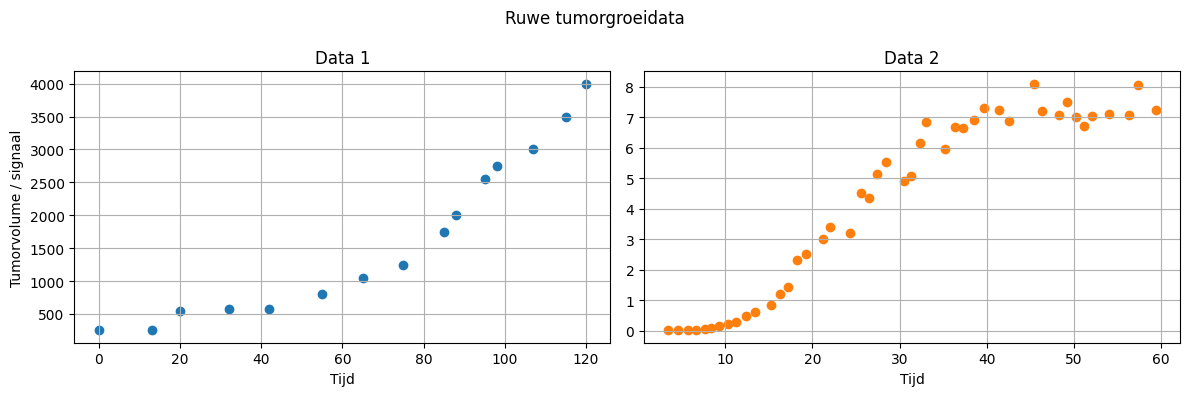

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)

axes[0].scatter(ts1, Vs1, color="tab:blue")
axes[0].set_title("Data 1")
axes[0].set_xlabel("Tijd")
axes[0].set_ylabel("Tumorvolume / signaal")

axes[1].scatter(ts2, Vs2, color="tab:orange")
axes[1].set_title("Data 2")
axes[1].set_xlabel("Tijd")

plt.suptitle("Ruwe tumorgroeidata")
plt.tight_layout()
plt.show()


### Functie: get_param_bounds(model_name, V)

Deze functie bepaalt automatisch **realistische parameterranges** voor elk 
tumorgroeimodel op basis van de dataset.

Voor elke dataset worden eerst twee waarden berekend:

- **Vmax**: het grootste gemeten volume  
- **Vmin**: het kleinste gemeten volume (met kleine buffer tegen nul)

Veel modellen gebruiken deze waarden om een biologische grens of asymptote te schatten.

Daarna geeft de functie per model een lijst terug met `(min, max)`-paren voor de 
parameters van dat model. Enkele voorbeelden:

- Logistische groei krijgt een bereik voor `Vmax` tussen `0.5 × max(V)` en `3 × max(V)`
- Het Gompertz-model krijgt een afkapvolume ("cap") tussen `0.5 × max(V)` en `5 × max(V)`
- Het Allee-model krijgt drie parameters: groeisnelheid, Vmin en Vmax

Deze dynamische parameterranges zorgen ervoor dat het fitproces:

- efficiënter is  
- biologisch plausibeler parameters vindt  
- en minder snel vastloopt of explodeert

De functie wordt gebruikt door de optimizer (`Searcher`) om alleen parameters te kiezen binnen realistische grenzen.

In [4]:
def get_param_bounds(model_name, V):
    """
    Geef (min, max) grenzen per parameter op basis van de data.
    V is de vector met gemeten volumes/waarden.
    """
    Vmax = float(max(V))
    Vmin = float(min(V))

    # kleine buffer tegen exact 0
    if Vmin <= 0:
        Vmin = Vmax * 0.001

    if model_name == "Lineair":
        # dV/dt = c
        return [(0.0, 100.0)]  # c

    elif model_name == "Exponentieel":
        # dV/dt = c * V
        return [(0.0, 0.5)]  # c

    elif model_name == "Mendelsohn":
        # dV/dt = c * V^d
        return [(0.0, 1.0), (0.0, 3.0)]  # c, d

    elif model_name == "Exp-afvlakkend":
        # dV/dt = c * (Vmax - V)
        return [(0.0, 1.0), (Vmax * 0.5, Vmax * 3.0)]  # c, Vmax (asymptote)

    elif model_name == "Logistisch":
        # dV/dt = c * V * (Vmax - V)
        return [(0.0, 0.5), (Vmax * 0.5, Vmax * 3.0)]  # c, Vmax

    elif model_name == "Montroll":
        # dV/dt = c * V * (Vmax^d - V^d)
        return [(0.0, 0.5), (Vmax * 0.5, Vmax * 3.0), (0.5, 3.0)]  # c, Vmax, d

    elif model_name == "Von Bertalanffy":
        # dV/dt = c * V^(2/3) - d * V
        return [(0.0, 1.0), (0.0, 1.0)]  # c, d

    elif model_name == "Gompertz-les":
        # dV/dt = c * V * ln(cap / V)
        return [(0.0, 0.5), (Vmax * 0.5, Vmax * 5.0)]  # c, cap

    elif model_name == "Gompertz-paper":
        # dV/dt = alpha * exp(-beta * t) * V
        return [(0.0, 1.0), (0.0, 0.5)]  # alpha, beta

    elif model_name == "Oppervlakte-gelimiteerd":
        # dV/dt = c * V / (V + d)^(1/3)
        return [(0.0, 1.0), (1.0, Vmax * 2.0)]  # c, d

    elif model_name == "Allee":
        # dV/dt = c * (V - Vmin) * (Vmax - V)
        return [
            (0.0, 0.5),             # c
            (0.0, Vmax * 0.7),      # Vmin
            (Vmax * 0.7, Vmax * 2)  # Vmax (Allee-Vmax)
        ]

    elif model_name == "Lineair-gelimiteerd":
        # dV/dt = c * V / (V + d)
        return [(0.0, 1.0), (1.0, Vmax * 2.0)]  # c, d

    else:
        raise ValueError(f"Onbekend model: {model_name}")

### Functie: `bounded_random_search(bounds, searcher, iters=2000, sigma=0.1)`

Deze functie voert een eenvoudige, maar effectieve **hill-climbing random search** uit om de optimale parameters voor een groeimodel te vinden. De zoekruimte wordt beperkt door vooraf gedefinieerde grenzen (`bounds`), zodat alleen **biologisch realistische** parameterwaarden worden geprobeerd.

#### Werking stap voor stap

1. **Initialisatie binnen de grenzen**  
   Voor elke parameter wordt een willekeurige startwaarde gekozen binnen het opgegeven interval `(min, max)`.  
   Hierdoor begint het algoritme altijd op een geldige positie in de parameter­ruimte.

2. **Startfout berekenen**  
   De kwaliteit van deze startparameters wordt gemeten met:

   \[
   \text{MSE} = \text{mean\_squared\_error}(\text{data}, \text{model})
   \]

   via `searcher.mean_squared_error()`.

3. **Iteratieve verbetering (hill-climbing)**  
   In elke iteratie wordt een **nieuw parameterkandidaat** voorgesteld door een kleine Gauss-verstoring toe te passen:

   \[
   p_{\text{nieuw}} = p_{\text{oud}} + \mathcal{N}(0, \sigma)
   \]

   waarna de waarde wordt **afgekapt binnen de grenzen** (`clamping`), zodat het algoritme nooit buiten de toegestane parameterwaarden gaat.

4. **Acceptatiecriterium**  
   - Als de nieuwe parameters een **lagere fout (MSE)** opleveren dan de huidige beste,
     dan worden ze **geaccepteerd** en vormen ze het nieuwe optimum.
   - Zo niet, dan worden ze genegeerd.

   Dit is het kenmerk van een **greedy hill-climber**: het beweegt alleen naar betere oplossingen.

5. **Resultaat**  
   Na het doorlopen van alle iteraties retourneert de functie:
   - de beste gevonden parameters,
   - de bijbehorende MSE.

#### Belangrijke eigenschappen

- **Robuust**: blijft altijd binnen de toegestane parameterranges.  
- **Lichtgewicht**: eenvoudiger dan genetische algoritmes of simulatie-gebaseerde optimalisatie.  
- **Geschikt voor kleine datasets** zoals in tumorgroeiexperimenten.  
- **Afhankelijk van `sigma`**:  
  - kleine `sigma` → fijnmazige lokale verbetering,  
  - grote `sigma` → globalere verkenning.

#### Toepassing in dit project

Deze functie vormt de kern van het automatisch fitten van tumorgroeimodellen.  
In combinatie met dataset-afhankelijke parametergrenzen (`get_param_bounds`) zorgt het voor een efficiënte en biologisch plausibele modeloptimalisatie.


In [5]:
def bounded_random_search(bounds, searcher, iters=2000, sigma=0.1):
    """
    Eenvoudige hill-climbing random search binnen gegeven grenzen.

    bounds : list van (min, max) per parameter
    searcher : jouw Searcher-instance
    """
    import random

    # start met random parameters binnen [min, max]
    params = [
        random.uniform(low, high)
        for (low, high) in bounds
    ]
    best_error = searcher.mean_squared_error(*params)

    for _ in range(iters):
        # voorstel nieuwe parameters (kleine Gauss-stap, binnen de grenzen clamped)
        candidate = []
        for (p, (low, high)) in zip(params, bounds):
            new_p = p + gauss(0.0, sigma)
            new_p = max(low, min(high, new_p))
            candidate.append(new_p)

        err = searcher.mean_squared_error(*candidate)
        if err < best_error:
            best_error = err
            params = candidate

    return params, best_error



### Functie: `fit_model_on_data(model_class, model_name, n_params, t, V, method="runge-kutta")`

Deze functie voert het complete proces uit van **het fitten van één tumorgroeimodel op een dataset**.  
Het combineert parameteroptimalisatie, foutberekening en numerieke simulatie tot één overzichtelijke stap.  
Hiermee vormt het de kern van de automatische modelvergelijking in dit project.

## 1. Initialiseren van de `Searcher`
De functie begint met het aanmaken van een `Searcher`-object:

- dit object kent het groeimodel,
- de gemeten data (`t` en `V`),
- het aantal modelparameters (`n_params`),
- en de gekozen oplossingsmethode (standaard: Runge–Kutta).

De `Searcher` wordt vervolgens gebruikt om de **mean squared error (MSE)** van kandidaat-parameters te berekenen.

## 2. Bepalen van parameterranges op basis van de data
Met:

```python
bounds = get_param_bounds(model_name, V)
```
worden dataset-afhankelijke grenzen bepaald voor de parameters van het model.
Hierdoor worden de parameters automatisch beperkt tot biologisch realistische waarden, zoals:

asymptotes gebaseerd op het maximum gemeten volume,

groeisnelheden binnen haalbare ranges,

realistische exponenten.

Dit maakt het fitproces stabieler en efficiënter.
## 3. Optimaliseren met bounded random search

De functie roept vervolgens:
```python
param_list, mse = bounded_random_search(bounds, searcher)
```

Hier wordt met een hill-climbing random search binnen de opgegeven grenzen gezocht naar de parameters die de MSE minimaliseren.

- Er wordt gestart met een willekeurige parametercombinatie.

- Kleine willekeurige (Gaussische) stappen worden genomen.

- Alleen verbeteringen worden geaccepteerd.

- De parameterwaarden blijven altijd binnen de grenzen.

Dit levert een beste parameterset en de bijbehorende foutwaarde (MSE).

Als de fout oneindig wordt (inf), wijst dit op een numeriek instabiel of ongeschikt model.
## 4. Gladde modelcurve simuleren

Wanneer er een geldige parameterfit is gevonden, wordt een Solver gebruikt om een gladde voorspelde curve te genereren. Deze curve wordt berekend met de Runge–Kutta-methode:

met 1000 tijdstappen voor een soepele lijn,

vanaf de eerste meettijd tot de laatste,

met het gemeten beginvolume als startpunt.

Dit levert twee arrays:

t_smooth: fijnmazige tijdstappen,

V_smooth: voorspelde tumorgroei volgens het model.

Als de simulatie numeriek vastloopt (zoals bij overflows, deling door nul of ongeldige waarden), wordt een NaN-curve teruggegeven en wordt de MSE op inf gezet. Hierdoor komt het model automatisch onderaan in de modelranglijst terecht.

## 5. Teruggegeven resultaat

De output is een dictionary met:

params – de beste gevonden parameters (als index:waarde-paren)

mse – de bijbehorende foutmaat

t_smooth – de tijdpunten van de gesimuleerde curve

V_smooth – de modelvoorspelling bij die tijdpunten

Dit resultaat wordt later gebruikt om:

modellen te plotten,

tabellen te maken,

en automatisch het best passende model te bepalen.

In [6]:
def fit_model_on_data(model_class, model_name, n_params, t, V, method="runge-kutta"):
    searcher = Searcher(
        real_vals=V,
        time_values=t,
        n_params=n_params,
        model=model_class,
        predict_function=method,
    )

    # 1) Parameterruimte op basis van data
    bounds = get_param_bounds(model_name, V)

    # 2) Zoeken binnen die grenzen
    param_list, mse = bounded_random_search(bounds, searcher)

    # Als MSE al inf is → model is gewoon slecht/numeriek instabiel
    if not np.isfinite(mse):
        t_smooth = np.linspace(float(t.min()), float(t.max()), 100)
        V_smooth = np.full_like(t_smooth, np.nan)
        param_dict = {i: p for i, p in enumerate(param_list)}
        return {
            "params": param_dict,
            "mse": float("inf"),
            "t_smooth": t_smooth,
            "V_smooth": V_smooth,
        }

    # 3) Gladde curve maken met Solver + Runge–Kutta
    t_min, t_max = float(t.min()), float(t.max())
    total_time = t_max - t_min

    try:
        solver = Solver(
            1000,              # n_steps
            total_time,        # time
            model_class,       # model
            float(V[0]),       # init_volume
            t_min,             # init_time
            *param_list        # modelparameters
        )
        t_smooth, V_smooth = solver.runge_kutta_function()

    except (OverflowError, ValueError, ZeroDivisionError, FloatingPointError):
        # Als het alsnog misgaat → markeer model als zeer slecht
        t_smooth = np.linspace(t_min, t_max, 100)
        V_smooth = np.full_like(t_smooth, np.nan)
        mse = float("inf")

    param_dict = {i: p for i, p in enumerate(param_list)}

    return {
        "params": param_dict,
        "mse": mse,
        "t_smooth": np.array(t_smooth),
        "V_smooth": np.array(V_smooth),
    }


## Functie: `compare_models_on_dataset(models_info, t, V, title="Modelvergelijking")`

Deze functie voert een volledige **modelvergelijking** uit voor één dataset.  
Het fitten, evalueren, rangschikken en visualiseren van alle modellen gebeurt hierin automatisch.

In [7]:
def compare_models_on_dataset(models_info, t, V, title="Modelvergelijking"):
    """
    models_info: lijst van (model_class, n_params, naam)
    """
    results = []
    curves = {}

    for model_class, n_params, name in models_info:
        print(f"Fitten van model: {name}")
        res = fit_model_on_data(model_class, name, n_params, t, V)
        results.append({
            "model": name,
            "n_params": n_params,
            "MSE": res["mse"],
            "params": res["params"],
        })
        curves[name] = res

    df = pd.DataFrame(results).sort_values("MSE").reset_index(drop=True)

    print("\nSamenvatting (gesorteerd op MSE):")
    display(df[["model", "n_params", "MSE"]])

    best_row = df.iloc[0]
    best_name = best_row["model"]
    best_params = best_row["params"]

    print(f"\nBeste model volgens MSE: {best_name}")
    print("Geschatte parameters (index → waarde):", best_params)

    # Visualisatie
    plt.figure(figsize=(7, 4))
    plt.scatter(t, V, color="k", label="Data")

    for name, res in curves.items():
        plt.plot(res["t_smooth"], res["V_smooth"], label=name)

    plt.title(title + f" (beste: {best_name})")
    plt.xlabel("Tijd")
    plt.ylabel("Tumorvolume / signaal")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return df, best_name, best_params, curves


### Lijst van te testen groeimodellen: `models_to_try`

In deze lijst worden alle tumorgroeimodellen verzameld die in de analyse worden meegenomen.  
Elk item in de lijst bestaat uit drie onderdelen:
(model_class, aantal_parameters, modelnaam_string)

Deze structuur maakt het eenvoudig om in één keer alle modellen te doorlopen, te fitten en met elkaar te vergelijken.

Hieronder staat een overzicht van alle opgenomen modellen:

---

## **1. Lineair model**
`(LinearGrowthModel, 1, "Lineair")`  
- Heeft één parameter (`c`).  
- Staat voor constante groeisnelheid (rechte lijn).

---

## **2. Exponentieel model**
`(ExponentialGrowthModel, 1, "Exponentieel")`  
- Één parameter (`c`).  
- Geschikt voor vroege fasen van tumorgroei met onbeperkte exponentiële toename.

---

## **3. Mendelsohn model**
`(MendelsohnGrowthModel, 2, "Mendelsohn")`  
- Twee parameters (`c`, `d`).  
- Generaliseert exponentiële groei door middel van een exponent `d`.

---

## **4. Exponentieel afvlakkend**
`(ExponentialSaturatingModel, 2, "Exp-afvlakkend")`  
- Twee parameters (`c`, `Vmax`).  
- Groeit snel in het begin maar vlakt af richting een asymptoot.

---

## **5. Logistisch model**
`(LogisticGrowthModel, 2, "Logistisch")`  
- Twee parameters (`c`, `Vmax`).  
- Klassiek model met aanvankelijke exponentiële groei en afvlakking door verzadiging.

---

## **6. Montroll model**
`(MontrollGrowthModel, 3, "Montroll")`  
- Drie parameters (`c`, `Vmax`, `d`).  
- Verfijning van het logistische model door extra flexibiliteit in de kromming.

---

## **7. Von Bertalanffy model**
`(VonBertalanffyModel, 2, "Von Bertalanffy")`  
- Twee parameters (`c`, `d`).  
- Biologisch gemotiveerd model waarbij groei afhankelijk is van oppervlakte- versus volumeschaling.

---

## **8. Gompertz-les model**
`(GompertzLesModel, 2, "Gompertz-les")`  
- Twee parameters (`c`, `cap`).  
- Een veelgebruikt tumorgroeimodel dat sterk afvlakt naarmate de tumor groter wordt.

---

## **9. Gompertz-paper model**
`(GompertzPaperModel, 2, "Gompertz-paper")`  
- Twee parameters (`alpha`, `beta`).  
- Alternatieve formulering uit wetenschappelijke literatuur.

---

## **10. Oppervlakte-gelimiteerd model**
`(SurfaceLimitedModel, 2, "Oppervlakte-gelimiteerd")`  
- Twee parameters (`c`, `d`).  
- Groei wordt beperkt door het vermogen van de tumor om voedingsstoffen via het oppervlak op te nemen.

---

## **11. Allee-model**
`(AlleeModel, 3, "Allee")`  
- Drie parameters (`c`, `Vmin`, `Vmax`).  
- Beschrijft trage groei (of zelfs afname) bij kleine populaties — relevant voor beginstadia.

---

## **12. Lineair-gelimiteerd model**
`(LinearLimitedModel, 2, "Lineair-gelimiteerd")`  
- Twee parameters (`c`, `d`).  
- Een verzadigende variant van lineaire groei.

---

### Samengevat

`models_to_try` bevat **alle tumorgroeimodellen** die in deze analyse worden getest.  
Door de uniforme structuur van `(class, n_params, naam)` kan het notebook alle modellen automatisch:

- fitten op de dataset,  
- vergelijken op basis van MSE,  
- de beste fit identificeren,  
- en alle modelcurves gezamenlijk visualiseren.




In [8]:
models_to_try = [
    (LinearGrowthModel,          1, "Lineair"),
    (ExponentialGrowthModel,     1, "Exponentieel"),
    (MendelsohnGrowthModel,      2, "Mendelsohn"),
    (ExponentialSaturatingModel, 2, "Exp-afvlakkend"),
    (LogisticGrowthModel,        2, "Logistisch"),
    (MontrollGrowthModel,        3, "Montroll"),
    (VonBertalanffyModel,        2, "Von Bertalanffy"),
    (GompertzLesModel,           2, "Gompertz-les"),
    (GompertzPaperModel,         2, "Gompertz-paper"),
    (SurfaceLimitedModel,        2, "Oppervlakte-gelimiteerd"),
    (AlleeModel,                 3, "Allee"),
    (LinearLimitedModel,         2, "Lineair-gelimiteerd"),
]



Run op eerste data

Fitten van model: Lineair
Fitten van model: Exponentieel
Fitten van model: Mendelsohn
Fitten van model: Exp-afvlakkend
Fitten van model: Logistisch
Fitten van model: Montroll
Fitten van model: Von Bertalanffy


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:63: RuntimeWarning: overflow encountered in scalar multiply
  return self.c * V * (self.Vmax - V)
/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:74: RuntimeWarning: invalid value encountered in scalar power
  return self.c * V * (self.Vmax ** self.d - V ** self.d)
/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:74: RuntimeWarning: overflow encountered in scalar power
  return self.c * V * (self.Vmax ** self.d - V ** self.d)


Fitten van model: Gompertz-les
Fitten van model: Gompertz-paper
Fitten van model: Oppervlakte-gelimiteerd
Fitten van model: Allee


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:131: RuntimeWarning: overflow encountered in scalar multiply
  return self.c * (V - self.Vmin) * (self.Vmax - V)


Fitten van model: Lineair-gelimiteerd

Samenvatting (gesorteerd op MSE):


,model,n_params,MSE
0,Mendelsohn,2,0.018462
1,Exponentieel,1,0.018700
2,Gompertz-paper,2,0.018745
3,Oppervlakte-gelimiteerd,2,0.020271
4,Von Bertalanffy,2,0.040362
5,Gompertz-les,2,0.050086
6,Lineair,1,0.127141
7,Exp-afvlakkend,2,0.141586
8,Lineair-gelimiteerd,2,3.160127
9,Allee,3,3.206385



Beste model volgens MSE: Mendelsohn
Geschatte parameters (index → waarde): {0: 0.01911659496816083, 1: 1.0282751318797922}


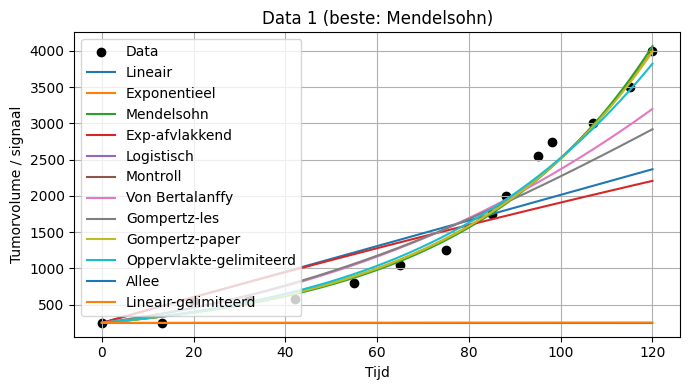

In [9]:
df1, best_name1, best_params1, curves1 = compare_models_on_dataset(
    models_info=models_to_try,
    t=ts1,
    V=Vs1,
    title="Data 1"
)


### Analyse van de modelvergelijking voor Dataset 1

De bovenstaande figuur toont de gemeten tumorgroeidata (zwarte punten) samen met de
voorspelde groeicurven van twaalf verschillende tumorgroeimodellen.
Alle modellen zijn automatisch gefit met hetzelfde optimalisatieproces
en vervolgens in één visualisatie samengebracht.

De tabel onder de figuur rangschikt de modellen op basis van hun
Mean Squared Error (MSE), waarbij een lagere MSE een betere overeenkomst
tussen model en data betekent



## Beste model voor Dataset 1: Mendelsohn

Uit de tabel blijkt dat het Mendelsohn-model de laagste MSE heeft:

| Model             | MSE        |
|------------------|------------|
| **Mendelsohn** | **0.018462** |

Dat sluit goed aan bij de waargenomen data: het tumorvolume neemt steeds sneller toe, zonder duidelijke afvlakking.
Direct daarna volgen – met iets hogere maar vergelijkbare MSE-waarden – onder andere:

- Exponentieel

- Gompertz-paper

Deze modellen kunnen eveneens versnellende groei beschrijven, maar het Mendelsohn-model heeft net genoeg extra flexibiliteit (via de exponent 
d) om de kromming van de data het best te volgen.



---

## Visuele interpretatie van de figuur

- De Mendelsohn-curve volgt de datapunten over vrijwel het hele traject:
vanaf de vroege meetmomenten tot aan het hoogste gemeten volume.

- Het Exponentiële model ligt dicht in de buurt, maar mist subtiele verschillen in kromming:
de groei is daar strikt proportioneel aan 
V
V, terwijl de data net iets sterker versnelt.

- Het Gompertz-paper model beschrijft een lichte afremming in de groeisnelheid op langere termijn;
dat past goed bij sommige trajecten, maar is voor deze dataset niet optimaal.

- Modellen met een duidelijke verzadigingsterm (Logistisch, Exp-afvlakkend,
Oppervlakte-gelimiteerd, Von Bertalanffy) wijken uiteindelijk af, omdat zij
een afvlakking van de groei voorspellen, terwijl de data nog duidelijk blijft stijgen.

Het Lineaire model onderschat de groei in het latere traject: de helling blijft te constant.

- Het Allee-model en enkele andere modellen met extra drempel- of limietparameters geven
een minder goede fit, omdat ze een te trage start of te sterke beperking van de groei opleggen.

## Waarom werkt het Mendelsohn-model hier het best?

Dataset 1 laat een groeipatroon zien dat:

- sterk stijgt,

- duidelijk versnelt (de kromme buigt naar boven),

- nog geen duidelijke verzadiging of stagnatie vertoont.

Dit is typerend voor een fase waarin de tumor nog relatief vrij kan doorgroeien,
met een groeisnelheid die sneller dan lineair met het volume toeneemt.

- Het Mendelsohn-model kan dit gedrag beter vangen dan:

- het Exponentiële model (te “rigide” exponent 
d=1
d=1);

- modellen met een maximale capaciteit (Logistisch, Gompertz-les, Exp-afvlakkend),
die al een afremming inbouwen die in de data nog niet zichtbaar is.

## Conclusie

Voor Dataset 1 beschrijft het Mendelsohn-model de tumorgroei het best:
het heeft de laagste MSE, sluit visueel nauw aan bij de meetpunten en kan de
sterk versnellende groei elegant verklaren. Dit wijst erop dat de tumor zich in
een fase bevindt van ongehinderde, snel versnellende groei, zonder duidelijke tekenen
van verzadiging of groeiremming.


Run op 2 data

Fitten van model: Lineair
Fitten van model: Exponentieel
Fitten van model: Mendelsohn
Fitten van model: Exp-afvlakkend
Fitten van model: Logistisch
Fitten van model: Montroll
Fitten van model: Von Bertalanffy
Fitten van model: Gompertz-les
Fitten van model: Gompertz-paper
Fitten van model: Oppervlakte-gelimiteerd
Fitten van model: Allee


/home/Jonkerjas/Documents/bioinf/jaar3/modelerren_van_kanker/Dynamic_Modelling/Dynamic_Modelling/tumor_models/models.py:131: RuntimeWarning: overflow encountered in scalar multiply
  return self.c * (V - self.Vmin) * (self.Vmax - V)


Fitten van model: Lineair-gelimiteerd

Samenvatting (gesorteerd op MSE):


,model,n_params,MSE
0,Gompertz-paper,2,0.044608
1,Lineair-gelimiteerd,2,0.107436
2,Von Bertalanffy,2,0.140788
3,Montroll,3,0.154244
4,Mendelsohn,2,0.215189
5,Gompertz-les,2,0.295815
6,Logistisch,2,0.694563
7,Lineair,1,0.713637
8,Exp-afvlakkend,2,0.834843
9,Oppervlakte-gelimiteerd,2,1.497636



Beste model volgens MSE: Gompertz-paper
Geschatte parameters (index → waarde): {0: 0.7237061235005801, 1: 0.0845829283841818}


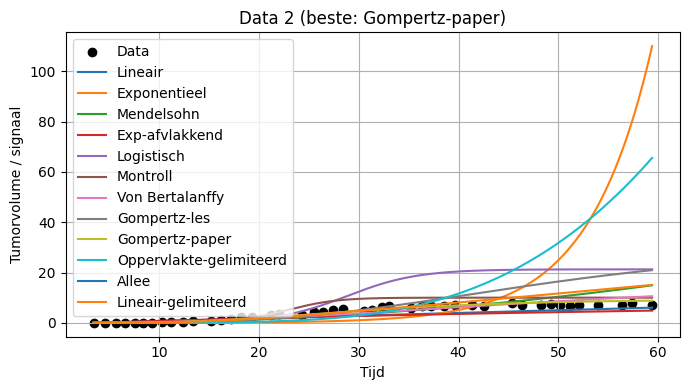

In [10]:
df2, best_name2, best_params2, curves2 = compare_models_on_dataset(
    models_info=models_to_try,
    t=ts2,
    V=Vs2,
    title="Data 2"
)


### Analyse van de modelvergelijking voor Dataset 2

De bovenstaande figuur toont de gemeten tumorgroeidata van Dataset 2 (zwarte punten),
samen met de voorspellingen van twaalf verschillende tumorgroeimodellen.
Alle modellen zijn automatisch gefit via dezelfde procedure en vervolgens visueel vergeleken.

De MSE-tabel hieronder rangschikt de modellen op basis van hun fitkwaliteit.

##  Beste model voor Dataset 2: Gompertz-paper

Uit de rangschikking blijkt dat het Gompertz-paper model het beste aansluit bij de data:

| Model        | MSE        |
|--------------|------------|
| **Gompertz-paper** | **0.044608** |

Precies dit patroon wordt waargenomen in Dataset 2.


##  Waarom past Gompertz-paper zo goed?
1. De groeicurve loopt snel op, maar vlakt al rond t ≈ 35–40 duidelijk af

De meetpunten laten zien dat de tumor na een vroege stijging een langdurige fase met bijna constante waarden bereikt (~7–8 eenheden).

2. Veel andere modellen voorspellen óf:

- te snelle groei (Mendelsohn, Exponentieel, Montroll) → grote overschatting op t > 40

- te vroege saturatie (Logistisch, Exp-afvlakkend, Oppervlakte-gelimiteerd) → onderschatting tussen t = 25–35

- lineaire toename (Lineair, Lineair-gelimiteerd) → mist de lichte kromming van de data

3. Gompertz-paper heeft precies de juiste flexibiliteit:

- begint bijna exponentieel,

- maar remt de groei al snel af,

- zonder een harde verzadigingswaarde op te leggen,

- en zonder volledig vlak te worden.

Visueel volgt de Gompertz-paper curve de datapunten dan ook het best over het hele bereik.


## Biologische interpretatie

Dataset 2 lijkt een tumor te beschrijven die:

- in een vroege fase vrij kan groeien,

- maar al snel sterk remmende factoren ervaart—bijv. zuurstoftekort, beperkte vascularisatie, of micro-omgevingseffecten,

- zonder dat er een harde verzadiging wordt bereikt.

Dit patroon komt bijzonder goed overeen met Gompertz-dynamiek, die ook in de literatuur vaak wordt gezien in tumoren die al vroeg door interne stress groeien.
## Conclusie

Het Gompertz-paper model beschrijft Dataset 2 het best:
Het heeft de laagste MSE, volgt visueel nauwkeurig de datapunten en biedt een biologisch plausibele verklaring voor de vroeg afremmende groei.

Het model vangt subtiele veranderingen in groeisnelheid beter dan lineaire of pure exponentiële modellen, en geeft geen te sterke verzadiging zoals veel andere saturerende modellen.